<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Импорт-библиотек-и-данных" data-toc-modified-id="Импорт-библиотек-и-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт библиотек и данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Проверка-данных" data-toc-modified-id="Проверка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка данных</a></span></li><li><span><a href="#Векторизация-изображений" data-toc-modified-id="Векторизация-изображений-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Векторизация изображений</a></span></li><li><span><a href="#Векторизация-текста" data-toc-modified-id="Векторизация-текста-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Векторизация текста</a></span></li><li><span><a href="#Объединение-векторов¶" data-toc-modified-id="Объединение-векторов¶-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Объединение векторов¶</a></span></li><li><span><a href="#Обучение-модели-предсказания-соответствия" data-toc-modified-id="Обучение-модели-предсказания-соответствия-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Обучение модели предсказания соответствия</a></span><ul class="toc-item"><li><span><a href="#Линейные-модели" data-toc-modified-id="Линейные-модели-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Линейные модели</a></span></li><li><span><a href="#Нейронная-сеть" data-toc-modified-id="Нейронная-сеть-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Нейронная сеть</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Поиск изображений по текстовому запросу

## Описание данных

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
 
 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке `test_images` содержатся изображения для тестирования модели.

## Импорт библиотек и данных

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import transformers 
import pickle
import time
#import helper
import os
import gc
from textwrap import wrap
from tqdm import tqdm, notebook, trange
from textwrap import wrap
from math import ceil


import torch
import torch.nn as nn
from torch import cuda
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
from PIL import Image
from torchvision import datasets, transforms, models
from torchmetrics import MeanSquaredError

from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit, train_test_split, GridSearchCV

from scipy.spatial.distance import cosine

In [6]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

# Зафиксируем random seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

CUDA is not available.  Training on CPU ...


In [7]:
PATH = 'C:/Users/Диана/data/MP_4/to_upload'
# PATH = '/kaggle/input/to-upload'

In [8]:
save_path = '/kaggle/working/'

def save_to_pkl(data, file_name):
    with open(f'{save_path}/{file_name}.pkl', 'wb') as f:
          pickle.dump(data, f)
    print(f'Saved to {save_path}/{file_name}.pkl')

def load_from_pkl(file_name):
    loaded_data = pickle.load(open(f'{save_path}/{file_name}.pkl', 'rb'))
    return loaded_data

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. 

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

* Доля исполнителей, подтвердивших, что текст соответствует картинке.
* Количество исполнителей, подтвердивших, что текст соответствует картинке.
* Количество исполнителей, подтвердивших, что текст не соответствует картинке.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

In [9]:
train_dataset = pd.read_csv(f'{PATH}/train_dataset.csv')
test_images = pd.read_csv(f'{PATH}//test_images.csv')
test_queries = pd.read_csv(f'{PATH}/test_queries.csv', sep='|', index_col=0)


expert_annotations = pd.read_csv(f'{PATH}/ExpertAnnotations.tsv', delimiter='\t', header=None)
expert_annotations.columns = ['image', 'query_id', 'exp_1', 'exp_2', 'exp_3']
crowd_annotations = pd.read_csv(f'{PATH}/CrowdAnnotations.tsv', delimiter='\t', header=None)
crowd_annotations.columns = ['image', 'query_id', 'conf_rate', 'confirm', 'not_confirm']

In [10]:
# Функция для вывода необходимой информации о данных
def display_table_info(name, data):
    print(name)
    data.info()
    display(data.head())
    print('')
    print('')
    print('')

display_table_info('train_dataset', train_dataset)
display_table_info('test_images', test_images)
display_table_info('test_queries', test_queries)
display_table_info('expert_annotations', expert_annotations)
display_table_info('crowd_annotations', crowd_annotations)

train_dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...





test_images
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg





test_queries
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg





expert_annotations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,image,query_id,exp_1,exp_2,exp_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2





crowd_annotations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   conf_rate    47830 non-null  float64
 3   confirm      47830 non-null  int64  
 4   not_confirm  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,conf_rate,confirm,not_confirm
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


**Количество уникальных изображений**

In [11]:
print("Количество уникальных изображений в обучающем наборе", train_dataset.image.nunique())
print("Количество уникальных изображений в тестовом наборе", test_queries.image.nunique())

Количество уникальных изображений в обучающем наборе 1000
Количество уникальных изображений в тестовом наборе 100


**Количество уникальных описаний**


In [12]:
print("Количество уникальных описаний в обучающем наборе", train_dataset.query_text.nunique())
print("Количество уникальных описаний в тестовом наборе", test_queries.query_text.nunique())

Количество уникальных описаний в обучающем наборе 977
Количество уникальных описаний в тестовом наборе 500


**Количество оценок**

In [13]:
print("Количество уникальных запросов (query_id) в expert_annotations:", expert_annotations.query_id.nunique())
print("Количество уникальных запросов (query_id) в crowd_annotations:", crowd_annotations.query_id.nunique())

Количество уникальных запросов (query_id) в expert_annotations: 977
Количество уникальных запросов (query_id) в crowd_annotations: 1000


In [14]:
expert_annotations['exp_total'] = (expert_annotations[['exp_1', 'exp_2', 'exp_3']]).median(axis=1)

Возмем медианную оценку всех экспертов для расчета агрегированной оценки экспертов. Приведем целевую переменную - оценки, в диапазон [0,1], используя масштабирование min-max.

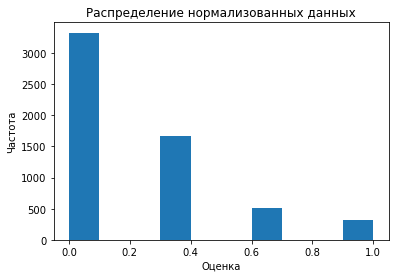

In [15]:
# применим методы нормализации по столбцу 'exp_total'
expert_annotations['exp_norm'] = (expert_annotations['exp_total'] - expert_annotations['exp_total'].min()) / (expert_annotations['exp_total'].max() - expert_annotations['exp_total'].min())    
  
# просмотрим нормализованные данные
expert_annotations['exp_norm'].plot.hist()
plt.title('Распределение нормализованных данных')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show();

**Большинство изображений в датасете не соответствует описанию**

In [16]:
display_table_info('expert_annotations', expert_annotations)

expert_annotations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      5822 non-null   object 
 1   query_id   5822 non-null   object 
 2   exp_1      5822 non-null   int64  
 3   exp_2      5822 non-null   int64  
 4   exp_3      5822 non-null   int64  
 5   exp_total  5822 non-null   float64
 6   exp_norm   5822 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 318.5+ KB


,image,query_id,exp_1,exp_2,exp_3,exp_total,exp_norm
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0,0.000000


In [17]:
display_table_info('crowd_annotations', crowd_annotations)

crowd_annotations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   conf_rate    47830 non-null  float64
 3   confirm      47830 non-null  int64  
 4   not_confirm  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,conf_rate,confirm,not_confirm
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [18]:
train_data = train_dataset\
.merge(expert_annotations[['image', 'query_id', 'exp_norm']], how='left', on=['image', 'query_id'])\
.merge(crowd_annotations[['image', 'query_id', 'conf_rate']], how='outer', on=['image', 'query_id'])

In [19]:
display_table_info('train_data', train_data)

train_data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  5822 non-null   object 
 3   exp_norm    5822 non-null   float64
 4   conf_rate   47830 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.3+ MB


,image,query_id,query_text,exp_norm,conf_rate
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,NaN
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.333333,0.0
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,1.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,NaN


In [20]:
query_id_text_corresp = train_dataset[['query_id', 'query_text']].drop_duplicates()

In [21]:
train_data = train_data.drop(columns=['query_text']).merge(query_id_text_corresp, how="left", on=['query_id'])

In [22]:
train_data['target'] = train_data[['conf_rate', 'exp_norm']].mean(axis=1)
train_data = train_data.drop(columns=['conf_rate', 'exp_norm'])

In [23]:
display_table_info('train_data', train_data)

train_data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


,image,query_id,query_text,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.166667
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000


В датасете есть пропуски, удалим их:

In [24]:
train_data.isnull().sum()

image            0
query_id         0
query_text    1109
target           0
dtype: int64

In [25]:
train_data.dropna(axis = 'index', inplace = True)
train_data.isnull().sum()

image         0
query_id      0
query_text    0
target        0
dtype: int64

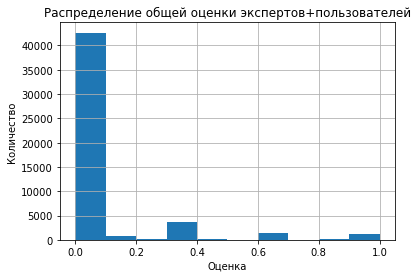

In [26]:
train_data['target'].hist()
plt.title('Распределение общей оценки экспертов+пользователей')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show();

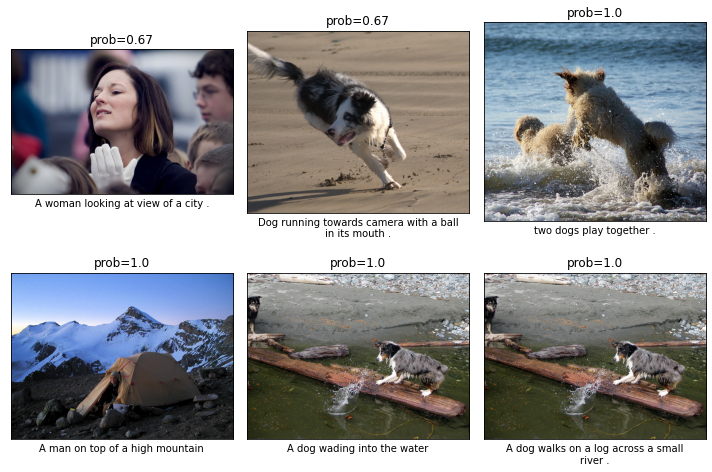

In [27]:
sample_data = train_data.sample(n=2000, random_state=0)
negative = sample_data[sample_data['target'] <= 0.5]
positive = sample_data[sample_data['target'] > 0.5]

fig = plt.figure(figsize=(10,10))

for i in range(6):
    fig.add_subplot(3, 3, i+1)
    
    img_name = positive.iloc[i]['image']
    img_text = positive.iloc[i]['query_text']
    img_text = '\n'.join(wrap(img_text, 40))
    img_target = positive.iloc[i]['target']
    img = mpimg.imread(f'{PATH}/train_images/{img_name}')
    
    plt.imshow(img)
    plt.title(f'prob={round(img_target, 2)}')
    plt.xlabel(img_text)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

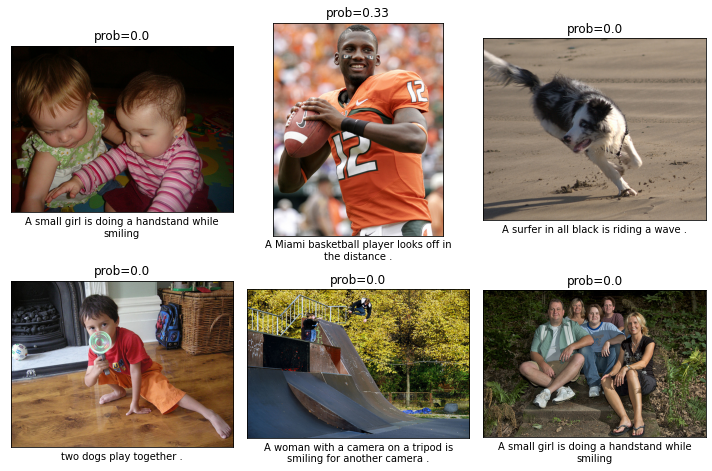

In [28]:
fig = plt.figure(figsize=(10,10))

for i in range(6):
    fig.add_subplot(3, 3, i+1)
    
    img_name = negative.iloc[i]['image']
    img_text = negative.iloc[i]['query_text']
    img_text = '\n'.join(wrap(img_text, 40))
    img_target = negative.iloc[i]['target']
    img = mpimg.imread(f'{PATH}/train_images/{img_name}')
    
    plt.imshow(img)
    plt.title(f'prob={round(img_target, 2)}')
    plt.xlabel(img_text)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Чтобы исполнить это требование, создадим, для начала, словарь, в который запишем слова, связанные с детьми и подростками:

In [29]:
ban_wordlist = ['girl', 
                'girls',
                'boy', 
                'boys',
                'child', 
                'children', 
                'baby',
                'babies',
                'young', 
                'teen', 
                'teenager', 
                'kid', 
                'kids',
                'toddler', 
                'toddlers',
                'minor', 
                'youth', 
                'junior',
                'infant',
                'infants']

In [30]:
def delete_ban_words(string, ban_wordlist):
    ban_wordlist = ban_wordlist
    lst = str(string).split()
    if len(set(lst).intersection(set(ban_wordlist))) != 0:
        res = np.nan
    else:
        res = string
    return res

In [31]:
def find_ban_text(string, ban_wordlist):
    ban_wordlist = ban_wordlist
    lst = str(string).split()
    if len(set(lst).intersection(set(ban_wordlist))) != 0:
        ban_comment = string
    else:
        ban_comment = np.nan
    return ban_comment

In [32]:
train_data['query_text']

0        A young child is wearing blue goggles and sitt...
1        A young child is wearing blue goggles and sitt...
2        A young child is wearing blue goggles and sitt...
3        A young child is wearing blue goggles and sitt...
4        A young child is wearing blue goggles and sitt...
                               ...                        
51318                       Two girls with orange shirts .
51319                     A woman in jeans rock climbing .
51320           A man is climbing the side of a mountain .
51321                        A person flipping upside down
51322    A person in a red shirt climbing up a rock fac...
Name: query_text, Length: 50214, dtype: object

In [33]:
ban_comments = train_data['query_text'].apply(lambda x: find_ban_text(x, ban_wordlist)).dropna()

In [34]:
ban_comments

0        A young child is wearing blue goggles and sitt...
1        A young child is wearing blue goggles and sitt...
2        A young child is wearing blue goggles and sitt...
3        A young child is wearing blue goggles and sitt...
4        A young child is wearing blue goggles and sitt...
                               ...                        
51287    a young man jumping a back flip off of a concr...
51291                         A boy climbs up some rocks .
51304       A teenage boy climbs an indoor climbing wall .
51308    A young child climbing a rock wall at a playgr...
51318                       Two girls with orange shirts .
Name: query_text, Length: 14411, dtype: object

In [35]:
# оставим в таблице только строки с запрещенными комментариями
train_data_ban = train_data[train_data['query_text'].isin(ban_comments)]
# убираем последние 2 символа из query_id
train_data_ban['query_id'] = train_data_ban['query_id'].map(lambda x: str(x)[:-2])
# создаем список запрещенных картинок, которые нужно удалить
ban_images = train_data_ban['query_id'].unique()

C:\Users\Диана\AppData\Local\Temp\ipykernel_14720\492378567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ban['query_id'] = train_data_ban['query_id'].map(lambda x: str(x)[:-2])


In [36]:
# Убираем из датафрейма все запрещенные картинки
train_data_clear = train_data[train_data['image'].isin(ban_images) == False]

In [37]:
display_table_info('train_data_clear', train_data_clear)

train_data_clear
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35764 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       35764 non-null  object 
 1   query_id    35764 non-null  object 
 2   query_text  35764 non-null  object 
 3   target      35764 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


,image,query_id,query_text,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0


In [38]:
print('Количество объектов в очищенном от запрещенных слов датасете:', train_data_clear.shape[0])

Количество объектов в очищенном от запрещенных слов датасете: 35764


## Векторизация текста

Проведем векторизации текста с помощью предобученной модели DistilBert

In [39]:
def text_to_vectors(texts_series):
    tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
    model.to(DEVICE)

    tokenized = texts_series.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)

    input_ids = torch.tensor(padded).to(DEVICE)
    attention_mask = torch.tensor(attention_mask).to(DEVICE)
    batch_size = 100
    embeddings = []

    for i in range(input_ids.shape[0] // batch_size + 1):
        batch = input_ids[batch_size*i:batch_size*(i+1)]
        attention_mask_batch = attention_mask[batch_size*i:batch_size*(i+1)]

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        torch.cuda.empty_cache()

    features = np.concatenate(embeddings)
    return features

In [40]:
try:
    train_text_vectors_big = load_from_pkl('train_text_vectors_big')
except:
    train_text_vectors_big = text_to_vectors(train_data_clear['query_text'])
    #save_to_pkl(train_text_vectors_big, 'train_text_vectors_big')

In [41]:
train_text_vectors_big.shape

(35764, 768)

## Векторизация изображений

Приведем фотографии в векторы с использованием предобученной модели Inception v3 

In [42]:
train_data_clear.sample()

,image,query_id,query_text,target
49724,56489627_e1de43de34.jpg,439037721_cdf1fc7358.jpg#2,Two people having a picnic by the shore .,0.0


In [43]:
train_data_clear = train_data_clear.drop('query_id', axis=1)

In [44]:
train_data_clear.sample(5)

,image,query_text,target
39377,3490736665_38710f4b91.jpg,A skateboarder in the air above his board on a...,0.000000
9003,1517721825_10176d0683.jpg,A person in a wetsuit is in midair while surfi...,0.000000
18964,2542662402_d781dd7f7c.jpg,The dog is jumping up beside a red wall .,0.000000
20305,260828892_7925d27865.jpg,A man rides a bike through a course .,0.000000
1544,2813033949_e19fa08805.jpg,A black dog and a white dog play in the street...,0.166667


In [45]:
def image_to_tensor(image_names, data):
    
    # Загрузим модель с предобученными параметрами
    model_extractor = models.inception_v3(pretrained=True)
    # Заморозим веса
    for param in model_extractor.parameters():
        param.requires_grad_(False)

    model_extractor.fc = nn.Identity()
    model_extractor = model_extractor.to(DEVICE)

    # Переведем модель в режим предсказания
    model_extractor.eval();

    output_vectors = []
    images_names_list = image_names.values
    preprocess = transforms.Compose([
      transforms.Resize(299),
      transforms.CenterCrop(299),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    if data == 'train':
        folder = 'train_images'
    elif data == 'test':
        folder = 'test_images'

    for img_name in images_names_list:
        img = Image.open(f"{PATH}/{folder}/{img_name}").convert('RGB')
        image_tensor = preprocess(img).unsqueeze(0)
        output_tensor = model_extractor(image_tensor.to(DEVICE)).flatten()
        output_vectors.append(output_tensor.cpu().numpy())
        torch.cuda.empty_cache()
    return np.array(output_vectors)

In [46]:
try:
    train_images_vectors_big = load_from_pkl('train_images_vectors_big')
except:
    train_images_vectors_big = image_to_tensor(image_names=train_data_clear['image'], data='train')
    #save_to_pkl(train_images_vectors_big, 'train_images_vectors_big')

C:\Program Files\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Program Files\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
train_images_vectors_big.shape

(35764, 2048)

## Объединение векторов¶

In [49]:
try: 
    features = load_from_pkl('features')
    target = load_from_pkl('target')
    train_data_clear = load_from_pkl('train_data_clear (1)')
except: 
    features = np.concatenate([train_images_vectors_big, train_text_vectors_big], axis=1)
    target = train_data_clear.target.values
    #save_to_pkl(features, 'features')
    #save_to_pkl(target, 'target')
    #save_to_pkl(train_data_clear, 'train_data_clear')

In [50]:
print("Размер данных", features.shape)
print(target.shape)

Размер данных (35764, 2816)
(35764,)


В резулльтате векторизации были получены вектора следующих размеров:
- Для одного описания: (768,)

- Для одного изображения: (2048,)

В результате признаковое пространство для одного объекта составило 2816 признаков.

Всего 35764 объекта

## Обучение модели предсказания соответствия

Таргет - это непрерывные числа (хоть и лежащие в диапазоне от нуля до единицы), будем решать задачу регрессии. В качестве метрики будем использовать RMSE. Таким образом, мы будем оценивать, насколько сильно отличается вероятность верного описания картинки от той вероятности, которую мы ранее вычислили и поместили в значение таргета.

Чтобы предсказания также лежали в диапазоне от нуля до единицы, все предсказанные значения ниже нуля будем приводить к нулю, а все предсказанные значения выше едииницы - к единице.

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки. Для того чтобы учесть изображения при разбиении, воспользуемся классом GroupShuffleSplit из библиотеки sklearn.model_selection.


In [51]:
gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

train_indices, valid_indices = next(gss.split(features, target, groups=train_data_clear["image"].values))

X_train = features[train_indices]
y_train = target[train_indices]
X_valid = features[valid_indices]
y_valid = target[valid_indices]

In [52]:
print('Размер тренировочной выборки:', X_train.shape)
print('Размер валидационной выборки:', X_valid.shape)

Размер тренировочной выборки: (28614, 2816)
Размер валидационной выборки: (7150, 2816)


### Линейные модели

In [53]:
def make_it_look_like_probs(pred_raw):
    pred_probs = np.where(pred_raw >= 0, pred_raw, 0)
    pred_probs = np.where(pred_probs <= 1, pred_probs, 1)
    return pred_probs

In [54]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_valid)
lr_pred = make_it_look_like_probs(lr_pred)
rmse_valid = mean_squared_error(y_valid, lr_pred, squared=False)
print(rmse_valid)

0.6887576016274041


In [55]:
en_reg = ElasticNet(alpha=0.001, random_state=45)
en_reg.fit(X_train,y_train)
en_preds = en_reg.predict(X_valid)
en_preds = make_it_look_like_probs(en_preds)
rmse_valid = mean_squared_error(y_valid, en_preds, squared=False)
print(rmse_valid)

0.21214591783345846


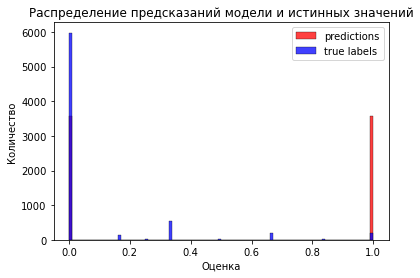

,0
count,7150.000000
mean,0.499580
std,0.500039
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [58]:
sns.histplot(lr_pred, bins=100, color='r', label='predictions')
sns.histplot(y_valid, bins=100, color='b', label='true labels')
plt.title('Распределение предсказаний модели и истинных значений')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.legend()
plt.show()
display(pd.DataFrame(lr_pred).describe())

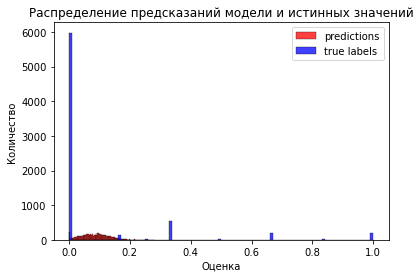

,0
count,7150.000000
mean,0.086170
std,0.045974
min,0.000000
25%,0.052668
50%,0.086208
75%,0.117192
max,0.282817


In [60]:
sns.histplot(en_preds, bins=100, color='r', label='predictions')
sns.histplot(y_valid, bins=100, color='b', label='true labels')
plt.title('Распределение предсказаний модели и истинных значений')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.legend()
plt.show()
display(pd.DataFrame(en_preds).describe())

Проверили качество работ двух линейных моделей LinearRegression и ElasticNet. 

LinearRegression - показала довольно низкий результат RMSE=0.74. У ElasticNet результат лучше RMSE=0.21. 

Однако ошибки этих моделей слишком большие, чтобы использовать их.

### Нейронная сеть

In [62]:
n_in_neurons, n_out_neurons = X_train.shape[1], 1

In [63]:
rmse = MeanSquaredError(squared = False).to(DEVICE)

In [64]:
class Net(nn.Module):

    def __init__(self, input_dim=n_in_neurons, num_layers=0, hidden_dim=64, output_dim=n_out_neurons, p=0.0, div=0):
        super().__init__()
        self.layers = torch.nn.Sequential()

        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i),
                                   torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module(f'batchnorm{i}',
                                   torch.nn.BatchNorm1d(hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
            if div!=0 and div!=1:
                hidden_dim = hidden_dim // 2

        self.layers.add_module('classifier', torch.nn.Linear(prev_size, output_dim))


    def forward(self, x):
        return self.layers(x)

    def fit(self,
            train,
            y_train,
            batch_size=16,
            num_epochs=10,
            lr=0.000001,
            val=None,
            y_val=None,
            plot_scores=True):
        
        self.train_scores = []
        self.best_train_score = 0
        self.best_train_epoch = 0
        
        self.val_scores = []
        self.best_val_score = 0
        self.best_val_epoch = 0
        
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss = nn.MSELoss().to(DEVICE)

        
        num_batches = ceil(train.shape[0] / batch_size)
        epoches = []

        for epoch in notebook.tqdm(range(num_epochs)):
            if epoch % 1 == 0:
                print(f'Epoch: {epoch}/{num_epochs}')
                try:
                    print(f'Loss = {loss_value}')
                    print()
                except UnboundLocalError:
                    pass
                
            self.train()
            order = np.random.permutation(train.shape[0])
            epoches.append(epoch)
            
            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size
                batch_indexes = order[start_index:start_index + batch_size]
                X_batch = train[batch_indexes].to(DEVICE)
                y_batch = y_train[batch_indexes].to(DEVICE)
                optimizer.zero_grad()
                preds = self.forward(X_batch).flatten().to(DEVICE)
                loss_value = loss(preds, y_batch)
                loss_value.backward()
                optimizer.step()
                
            self.eval()
            
            preds = self.forward(train).flatten().to(DEVICE)
            score = float(rmse(preds, y_train))
            self.train_scores.append(score)
            
            if val is not None and y_val is not None:
                preds = self.forward(val).flatten()
                score = float(loss(preds, y_val))
                self.val_scores.append(score)
        
        self.best_train_score = min(self.train_scores)
        self.best_train_epoch = np.argmin(self.train_scores)
        
        try:
            self.best_val_score = min(self.val_scores)
            self.best_val_epoch = np.argmin(self.val_scores)
        except:
            pass

        if plot_scores:
            sns.lineplot(x=epoches, y=self.train_scores, label='train')
            
            print(f'Best train epoch {self.best_train_epoch}')
            print(f'Best train score {self.best_train_score:0.2f}')
        
            if val is not None and y_val is not None:
                sns.lineplot(x=epoches, y=self.val_scores, label='val')
            
                print(f'Best val epoch {self.best_val_epoch}')
                print(f'Best val score {self.best_val_score:0.2f}')
            plt.title('Metric by epoch')
            plt.xlabel('Num Epoch')
            plt.ylabel('rmse')
            plt.legend()
            plt.grid()
            plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0/10
Epoch: 1/10
Loss = 0.13445819914340973

Epoch: 2/10
Loss = 0.041526760905981064

Epoch: 3/10
Loss = 0.21684187650680542

Epoch: 4/10
Loss = 0.328691691160202

Epoch: 5/10
Loss = 0.23617391288280487

Epoch: 6/10
Loss = 0.15457592904567719

Epoch: 7/10
Loss = 0.11216891556978226

Epoch: 8/10
Loss = 0.4044688940048218

Epoch: 9/10
Loss = 0.04448561742901802

Best train epoch 9
Best train score 0.32
Best val epoch 9
Best val score 0.10


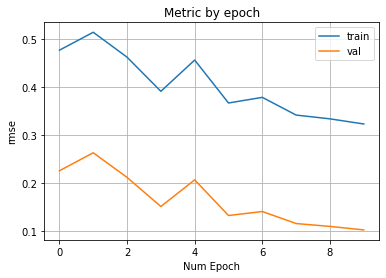

In [65]:
X_train_tensor = torch.FloatTensor(X_train).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train).to(DEVICE)

X_valid_tensor = torch.FloatTensor(X_valid).to(DEVICE)
y_valid_tensor = torch.FloatTensor(y_valid).to(DEVICE)

fc_nn = Net(X_train_tensor.shape[1], 256, 64, 1, 0.1).to(DEVICE)
fc_nn.fit(X_train_tensor,
          y_train_tensor,
          val=X_valid_tensor,
          y_val=y_valid_tensor,
          num_epochs=10,
          batch_size=32)

Нейронная сеть показал RMSE приблизительно 0.04 на валидационной выборке. Используем данную архитектуру для тестирования

## Тестирование модели

In [66]:
# Переводим тестовые изображения в вектора
test_images_vectors = image_to_tensor(image_names=test_images['image'], data='test')

# Получаем 10 случайных описаний
random_queries = test_queries['query_text'].sample(10, random_state=0)

test_images_vectors.shape

C:\Program Files\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Program Files\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(100, 2048)

In [ ]:
#save_to_pkl(test_images_vectors, 'test_images_vectors')

In [ ]:
#test_images_vectors = load_from_pkl('test_images_vectors')

In [67]:
random_queries = test_queries['query_text'].sample(10, random_state=0)

In [77]:
# Функция, которая показывает дисклеймер, если описание попадает под ограничения
def show_disclaimer(string, ban_wordlist):
    ban_wordlist = ban_wordlist
    lst = string.split(' ')
    if len(set(lst).intersection(set(ban_wordlist))) != 0:
        print('You asked for:', string)
        print('This image is unavailable in your country in compliance with local laws.')
        return True
    else:
        return False

# Функция, которая выводит наиболее релевантные изображения по текстовому запросу
def show_related_images(query):
    text = query
    disclaimer = show_disclaimer(text.values[0], ban_wordlist)
    if not disclaimer:
        # Переводим текст в вектор.
        text_vector = text_to_vectors(text)
        # Получаем массив с вектором текста, с количеством строк равным количеству изображений.
        text_vector_array = np.full((test_images_vectors.shape[0], text_vector.shape[1]), text_vector)
        # Конкатенируем вектора всех ихображений с ветором текста описания и переводим в тензор
        image_text_vectors = np.concatenate([test_images_vectors, text_vector_array], axis=1)
        image_text_vectors_t = torch.FloatTensor(image_text_vectors)
  
        # Предсказываем вероятность совпадения текста и изображения для всех изображений и данного текста описания
        fc_nn.eval()
        fc_nn.cpu()
        pred = fc_nn(image_text_vectors_t).flatten()
        pred_probs = make_it_look_like_probs(pred.detach().cpu().numpy())
  
        # Получаем индексы четырех самых высоких вероятностей
        ind = np.argpartition(pred_probs, -4)[-4:]
        # Получаем четрыре самые высокие вероятности
        top_probs = pred_probs[ind]
        # Получаем четыре изображения, для которых модель предсказала наиболее вероятное совпадение с текстом
        top_images = test_images.values[ind].flatten()

        # Выводим изображения на экран
        fig = plt.figure(figsize=(5, 5))
        plt.suptitle(*text.values, y=1.05)
        for i in range(4):
            fig.add_subplot(2, 2, i+1)
            img_name = top_images[i]
            img_target = top_probs[i]
            img = mpimg.imread(f'{PATH}/test_images/{img_name}')
            plt.imshow(img)
            plt.xlabel(f'prob={img_target}')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.show()

You asked for: A boy plays basketball .
This image is unavailable in your country in compliance with local laws.


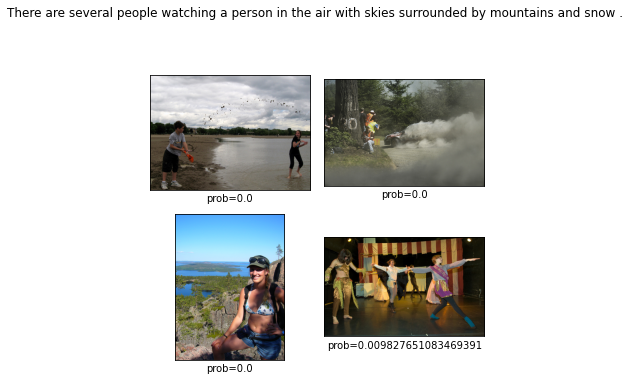

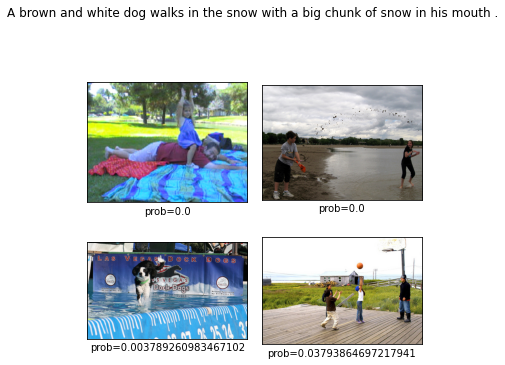

You asked for: A man and two boys standing in spraying water .
This image is unavailable in your country in compliance with local laws.


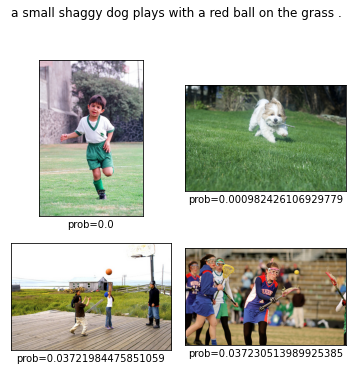

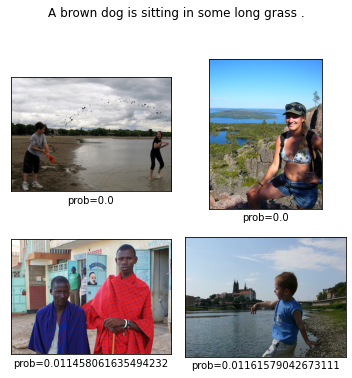

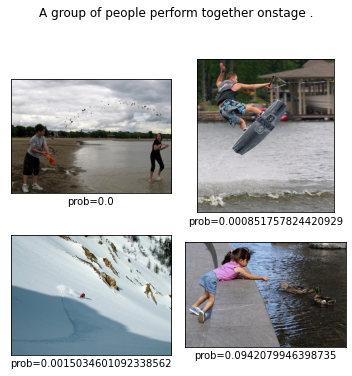

You asked for: I child slides into a wading pool full of water while an adult tosses a bucket of water on them .
This image is unavailable in your country in compliance with local laws.


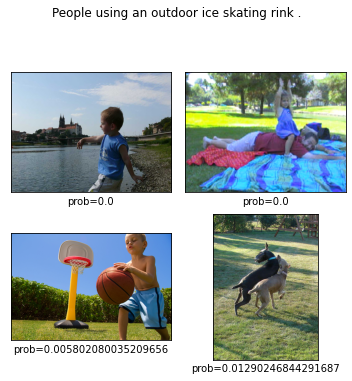

In [78]:
for i in range(9):
    show_related_images(query=random_queries[0+i:1+i])

## Выводы

Таргет был сгенерирован на основе аггрегированных оценок экспертов и краудсорсинга. Таргет - оценка схожести описания и изображения, которая лежит в диапазоне от нуля до единицы. 

Было принято решать задачу регрессии. Метрика качества - RMSE. 

Качество работы линейной регрессии оказалось не очень хорошим. Поэтому была проверена работа нейронной сети. Качество, которое она показал после 10 эпох обучения является удовлетворительным - приблизительно 0.04 rmse. При проверке на тестовых данных модель показала низкое качество. В итоге, она выдавала изображения, на которых контекст сложно сказать, что схож с описанием. 

К сожалению работают сами модели не очень. И причин тут несколько - мало данных, не очень правильный подход. На мой взгляд более перспективным было бы привести ембеддинги изображений и текстов к одной размерности в одно пространство (через обучаемые слои) и в качестве меры близости использовать косинусное расстояние.